#Project overview
- the aim of this project is classify people's emotions based on their face images

- You have been hired by a startup in San Diego to build, train and deploy a system that automatically monitors people emotions and expressions

- the team has collected more than 20000 facial images, with their associated facial expression labels and around 2000 images with their facial key-point annotations

- We will create a deep learning model based on Convolutional Neural Network and Residual Blocks to predict facial key-points

In [233]:
#IMPORT LIBRARIES AND DATASETS
# Mount the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [234]:
%cd /content/drive/My Drive/Colab Notebooks/Emotion AI Dataset/


[Errno 2] No such file or directory: '/content/drive/My Drive/Colab Notebooks/Emotion AI Dataset/'
/content


In [235]:
# Import the necessary packages

import pandas as pd
import numpy as np
import os
import PIL
import seaborn as sns
import pickle
from PIL import *
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.python.keras import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from keras import optimizers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow

In [236]:
# load facial key points data
keyfacial_df = pd.read_csv('/content/drive/My Drive//Emotion AI Dataset/data.csv')

In [237]:
keyfacial_df

left_eye_center_x  left_eye_center_y  right_eye_center_x  \
0             66.033564          39.002274           30.227008   
1             64.332936          34.970077           29.949277   
2             65.057053          34.909642           30.903789   
3             65.225739          37.261774           32.023096   
4             66.725301          39.621261           32.244810   
...                 ...                ...                 ...   
2135          67.180378          35.816373           33.239956   
2136          65.724490          36.301020           25.377551   
2137          68.430866          38.651975           28.895857   
2138          64.152180          30.691592           27.000898   
2139          66.683755          34.483429           30.784490   

      right_eye_center_y  left_eye_inner_corner_x  left_eye_inner_corner_y  \
0              36.421678                59.582075                39.647423   
1              33.448715                58.856170                35.274349   
2              34.909642                59.412000                36.320968   
3              37.261774                60.003339                39.127179   
4              38.042032                58.565890                39.621261   
...                  ...                      ...                      ...   
2135           34.921932                59.347973                37.000904   
2136           37.311224                58.530612                37.739796   
2137           37.617027                61.659350                40.100902   
2138           40.868082                56.505624                34.126963   
2139           38.578939                59.255347                36.065143   

      left_eye_outer_corner_x  left_eye_outer_corner_y  \
0                   73.130346                39.969997   
1                   70.722723                36.187166   
2                   70.984421                36.320968   
3                   72.314713                38.380967   
4                   72.515926                39.884466   
...                       ...                      ...   
2135                72.667896                37.097600   
2136                74.448980                37.525510   
2137                75.586792                40.219182   
2138                73.436776                28.556335   
2139                73.942694                34.624653   

      right_eye_inner_corner_x  right_eye_inner_corner_y  ...  nose_tip_y  \
0                    36.356571                 37.389402  ...   57.066803   
1                    36.034723                 34.361532  ...   55.660936   
2                    37.678105                 36.320968  ...   53.538947   
3                    37.618643                 38.754115  ...   54.166539   
4                    36.982380                 39.094852  ...   64.889521   
...                        ...                       ...  ...         ...   
2135                 39.404349                 36.589944  ...   60.065396   
2136                 33.551020                 38.107143  ...   62.472789   
2137                 37.665118                 39.087245  ...   63.289576   
2138                 34.746122                 40.506939  ...   59.735799   
2139                 37.478531                 39.398041  ...   59.269388   

      mouth_left_corner_x  mouth_left_corner_y  mouth_right_corner_x  \
0               61.195308            79.970165             28.614496   
1               56.421447            76.352000             35.122383   
2               60.822947            73.014316             33.726316   
3               65.598887            72.703722             37.245496   
4               60.671411            77.523239             31.191755   
...                   ...                  ...                   ...   
2135            64.397610            73.248393             35.446431   
2136            66.928121            79.229046             28.015377   
2137  

In [238]:
# Obtain relavant information about the dataframe
keyfacial_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2140 entries, 0 to 2139
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          2140 non-null   float64
 1   left_eye_center_y          2140 non-null   float64
 2   right_eye_center_x         2140 non-null   float64
 3   right_eye_center_y         2140 non-null   float64
 4   left_eye_inner_corner_x    2140 non-null   float64
 5   left_eye_inner_corner_y    2140 non-null   float64
 6   left_eye_outer_corner_x    2140 non-null   float64
 7   left_eye_outer_corner_y    2140 non-null   float64
 8   right_eye_inner_corner_x   2140 non-null   float64
 9   right_eye_inner_corner_y   2140 non-null   float64
 10  right_eye_outer_corner_x   2140 non-null   float64
 11  right_eye_outer_corner_y   2140 non-null   float64
 12  left_eyebrow_inner_end_x   2140 non-null   float64
 13  left_eyebrow_inner_end_y   2140 non-null   float

In [239]:
#check if null values exist in the dataframe
keyfacial_df.isnull().sum()

left_eye_center_x            0
left_eye_center_y            0
right_eye_center_x           0
right_eye_center_y           0
left_eye_inner_corner_x      0
left_eye_inner_corner_y      0
left_eye_outer_corner_x      0
left_eye_outer_corner_y      0
right_eye_inner_corner_x     0
right_eye_inner_corner_y     0
right_eye_outer_corner_x     0
right_eye_outer_corner_y     0
left_eyebrow_inner_end_x     0
left_eyebrow_inner_end_y     0
left_eyebrow_outer_end_x     0
left_eyebrow_outer_end_y     0
right_eyebrow_inner_end_x    0
right_eyebrow_inner_end_y    0
right_eyebrow_outer_end_x    0
right_eyebrow_outer_end_y    0
nose_tip_x                   0
nose_tip_y                   0
mouth_left_corner_x          0
mouth_left_corner_y          0
mouth_right_corner_x         0
mouth_right_corner_y         0
mouth_center_top_lip_x       0
mouth_center_top_lip_y       0
mouth_center_bottom_lip_x    0
mouth_center_bottom_lip_y    0
Image                        0
dtype: int64

In [240]:
keyfacial_df['Image'].shape

(2140,)

In [241]:
#Since values for the image are given as space separated string, separate the values string ' ' as separator
#then convert this into numpy array using np.fromstring and convert the obtained 1D array into 2D array of shape (96, 96)

keyfacial_df['Image'] = keyfacial_df['Image'].apply(lambda x: np.fromstring(x, dtype = int, sep = ' ').reshape(96, 96))

In [242]:
#average, minimum and maximum values of right_eye_center_x'
keyfacial_df.describe()

left_eye_center_x  left_eye_center_y  right_eye_center_x  \
count        2140.000000        2140.000000         2140.000000   
mean           66.221549          36.842274           29.640269   
std             2.087683           2.294027            2.051575   
min            47.835757          23.832996           18.922611   
25%            65.046300          35.468842           28.472224   
50%            66.129065          36.913319           29.655440   
75%            67.332093          38.286438           30.858673   
max            78.013082          46.132421           42.495172   

       right_eye_center_y  left_eye_inner_corner_x  left_eye_inner_corner_y  \
count         2140.000000              2140.000000              2140.000000   
mean            37.063815                59.272128                37.856014   
std              2.234334                 2.005631                 2.034500   
min             24.773072                41.779381                27.190098   
25%             35.818377                58.113054                36.607950   
50%             37.048085                59.327154                37.845220   
75%             38.333884                60.521492                39.195431   
max             45.980981                69.023030                47.190316   

       left_eye_outer_corner_x  left_eye_outer_corner_y  \
count              2140.000000              2140.000000   
mean                 73.412473                37.640110   
std                   2.701639                 2.684162   
min                  52.947144                26.250023   
25%                  71.741978                36.102409   
50%                  73.240045                37.624207   
75%                  74.978684                39.308331   
max                  87.032252                49.653825   

       right_eye_inner_corner_x  right_eye_inner_corner_y  ...   nose_tip_x  \
count               2140.000000               2140.000000  ...  2140.000000   
mean                  36.603107                 37.920852  ...    47.952141   
std                    1.822784                  2.009505  ...     3.276053   
min                   24.112624                 26.250023  ...    24.472590   
25%                   35.495730                 36.766783  ...    46.495330   
50%                   36.620735                 37.920336  ...    47.900511   
75%                   37.665280                 39.143921  ...    49.260657   
max                   47.293746                 44.887301  ...    65.279654   

        nose_tip_y  mouth_left_corner_x  mouth_left_corner_y  \
count  2140.000000          2140.000000          2140.000000   
mean     57.253926            63.419076            75.887660   
std       4.528635             3.650131             4.438565   
min      41.558400            43.869480            57.023258   
25%      54.466000            61.341291            72.874263   
50%      57.638582            63.199057            75.682465   
75%      60.303524            65.302398            78.774969   
max      75.992731            84.767123            94.673637   

       mouth_right_corner_x  mouth_right_corner_y  mouth_center_top_lip_x  \
count           2140.000000           2140.000000             2140.000000   
mean              32.967365             76.134065               48.081325   
std                3.595103              4.259514                2.723274   
min                9.778137             56.690208               32.260312   
25%               30.879288             73.280038               46.580004   
50%               33.034022             75.941985               47.939031   
75%               35.063575             78.884031               49.290000   
max               50.973348             93.443176               61.804506   

       mouth_center_top_lip_y  mouth_center_bottom_lip_x  \
count             2140.000000                2140.000000   
mean                72.681125                  48.149654

# Perform image visualization


<ipython-input-243-0ee3f7dbe48a>:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(keyfacial_df.loc[i][j-1], keyfacial_df.loc[i][j], 'rx')


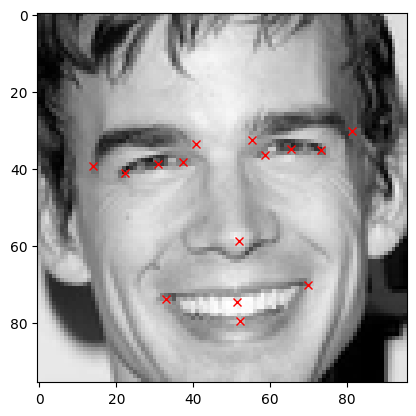

In [243]:
#plot a random image from the dataset along with facial keypoints
#x coordinates and y coordinates
#we access their value using .loc command, which get the values for coordinates of the image based on the column it is refering to
i = np.random.randint(1, len(keyfacial_df))
plt.imshow(keyfacial_df['Image'][i], cmap = 'gray')
for j in range(1, 31, 2):
  plt.plot(keyfacial_df.loc[i][j-1], keyfacial_df.loc[i][j], 'rx')

<ipython-input-244-9c09ee683fac>:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(keyfacial_df.loc[i][j-1], keyfacial_df.loc[i][j], 'rx')


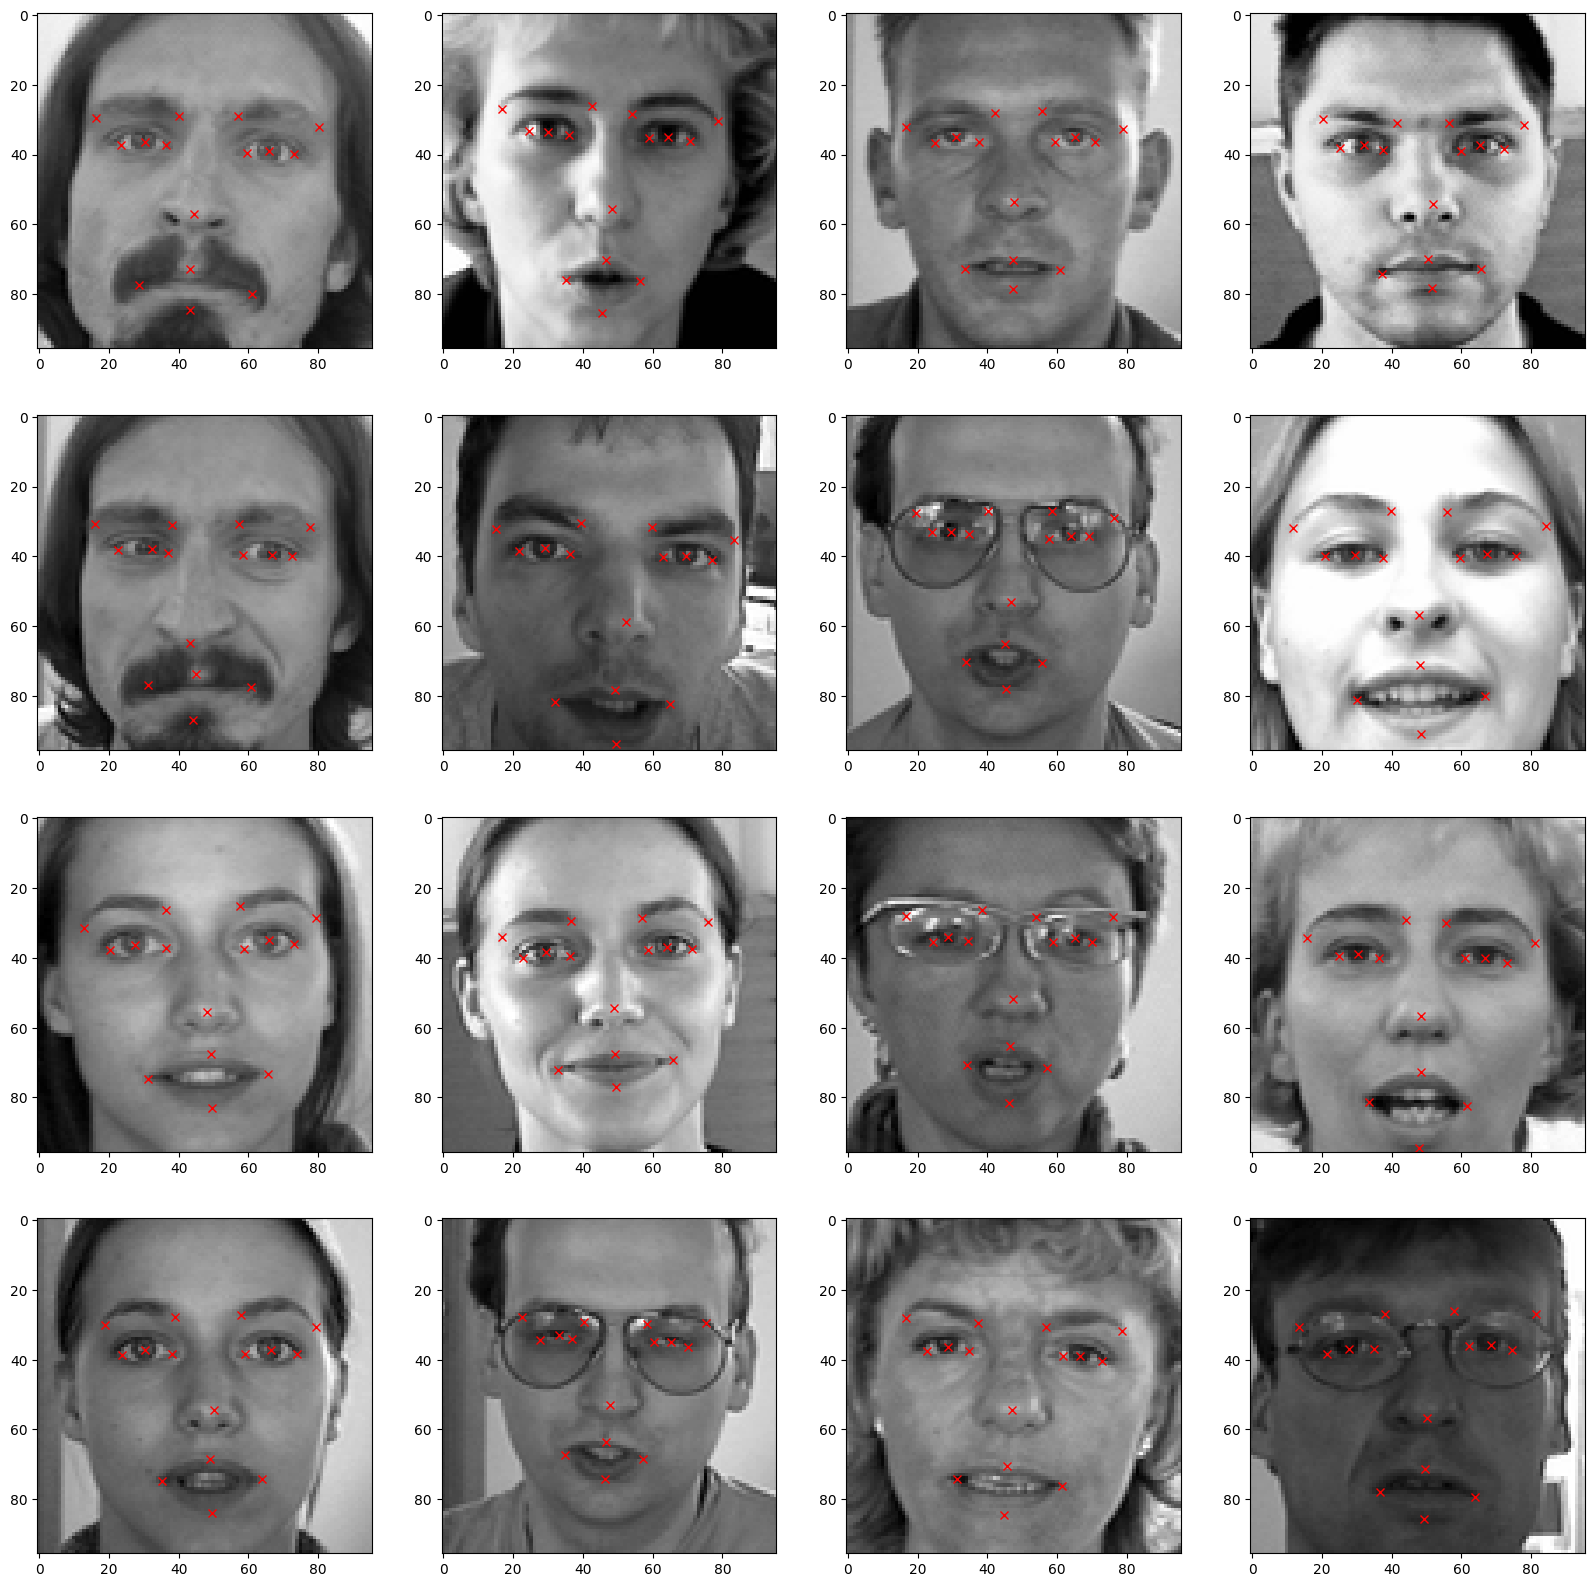

In [244]:
#lets view more images in a grid format
fig = plt.figure(figsize=(20, 20))

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1)
    image = plt.imshow(keyfacial_df['Image'][i],cmap = 'gray')
    for j in range(1,31,2):
        plt.plot(keyfacial_df.loc[i][j-1], keyfacial_df.loc[i][j], 'rx')

<ipython-input-245-32e68a82d653>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(keyfacial_df.loc[k][j-1], keyfacial_df.loc[k][j], 'rx')


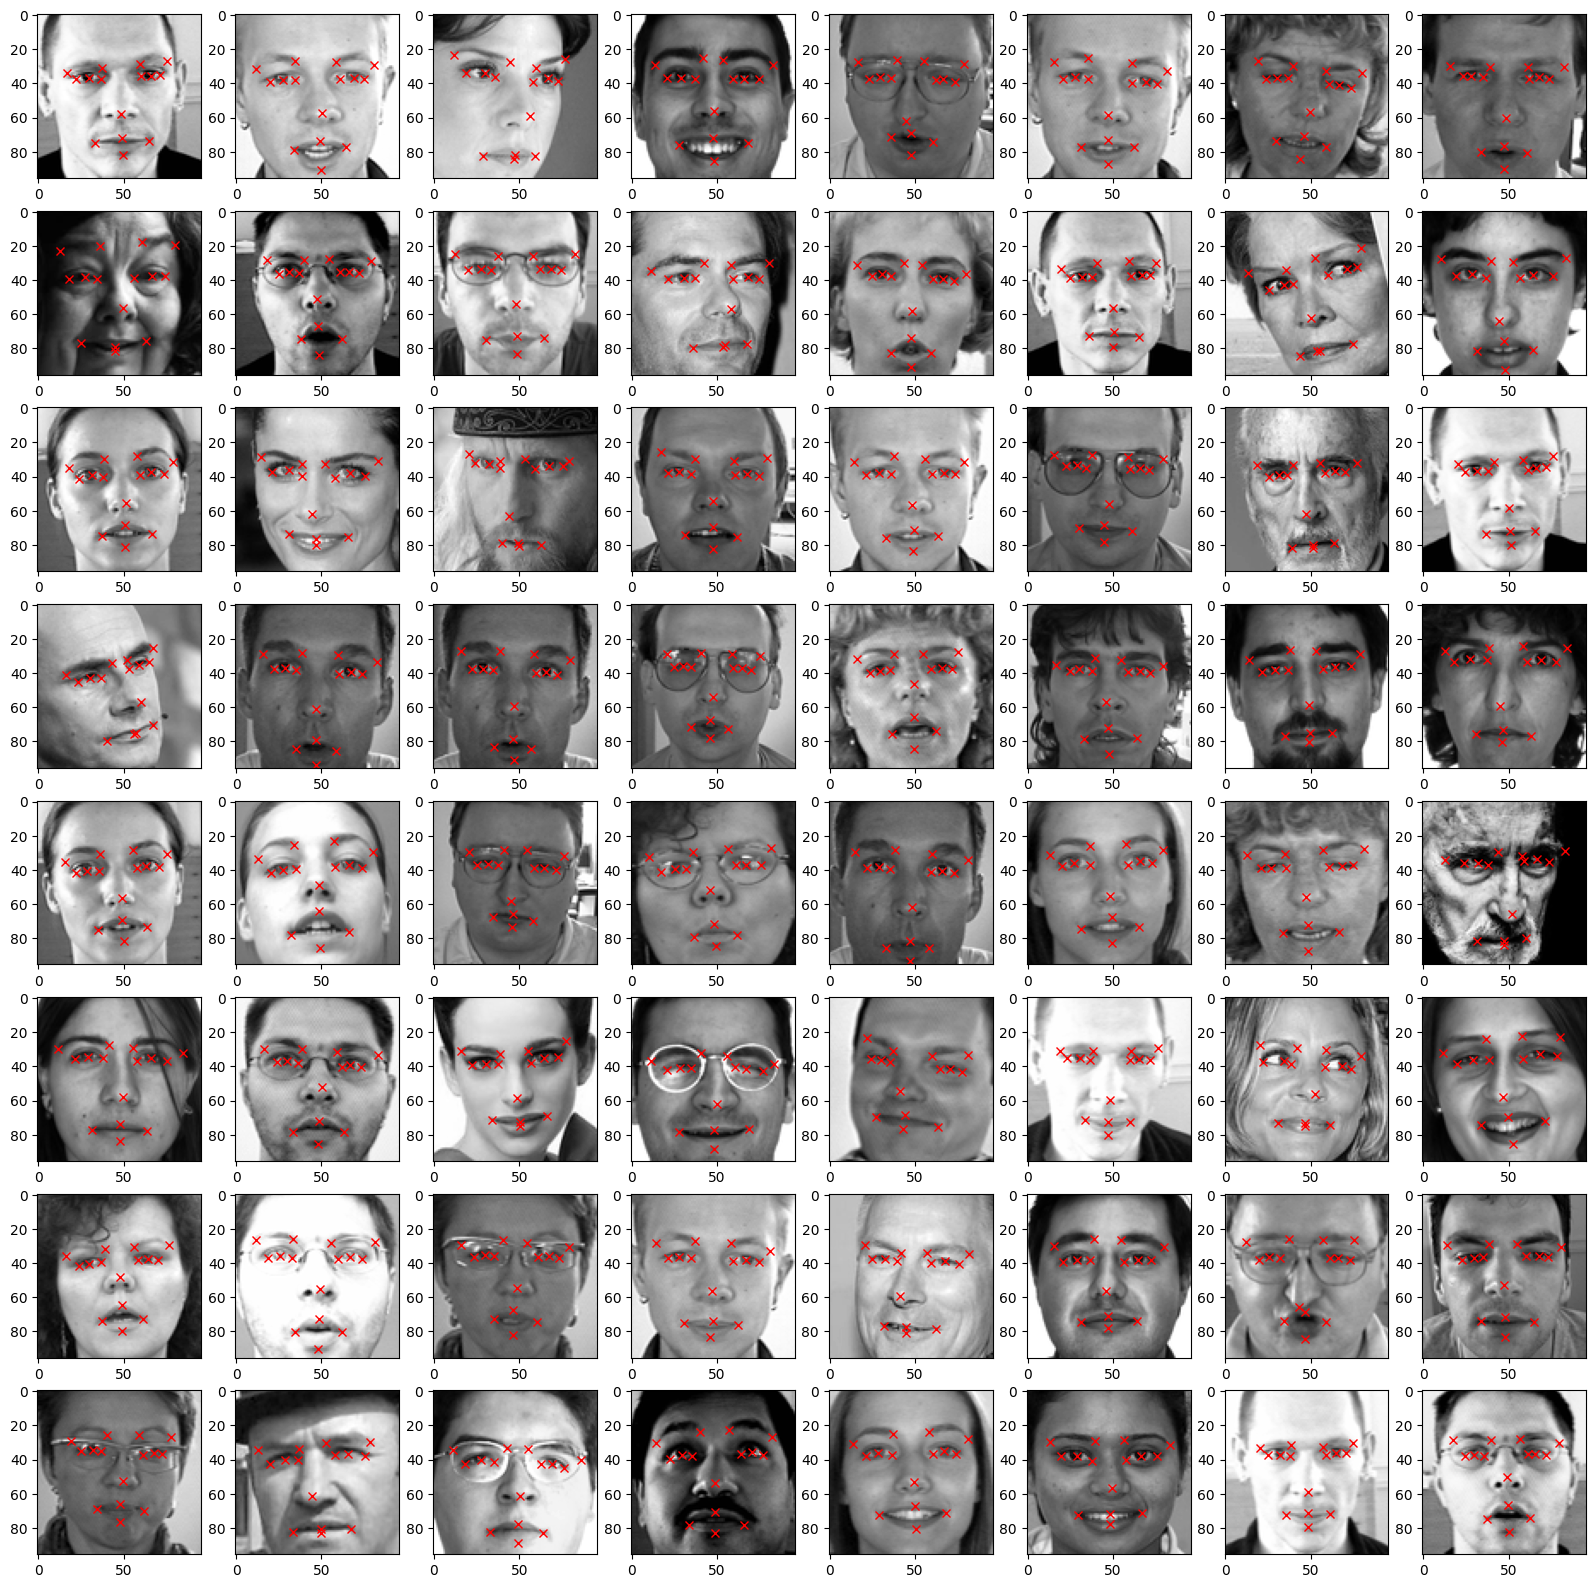

In [245]:
#perform a sanity check on the data by randomly visualizing 64 new images along with their cooresponding key points
import random
#view more images in a grid format
fig = plt.figure(figsize=(20, 20))

for i in range(64):
    k = random.randint(1, len(keyfacial_df))
    ax = fig.add_subplot(8, 8, i + 1)
    image = plt.imshow(keyfacial_df['Image'][k],cmap = 'gray')
    for j in range(1,31,2):
        plt.plot(keyfacial_df.loc[k][j-1], keyfacial_df.loc[k][j], 'rx')


# Perform image augmentation


In [246]:
#create a new copy of the dataframe
import copy
keyfacial_df_copy = copy.copy(keyfacial_df)

In [247]:
#obtain the column in the dataframe
columns = keyfacial_df_copy.columns[:-1]
columns

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y'],
      dtype='object')

In [248]:
#horizontal flip - flip the images along y axis

#since we are flipping horizontally, y coordinate values would be the same
#only x coordinate values would change, all we have to do is to subtract our x-coordinate values from width of the image (96)
#horizontal flip - flip the images along y axis
keyfacial_df_copy['Image'] = keyfacial_df_copy['Image'].apply(lambda x: np.flip(x, axis = 1))

#since we are flipping horizontally, y coordinate values would be the same
#only x coordinate values would change, all we have to do is to subtract our x-coordinate values from width of the image (96)
for i in range(len(columns)):
  if i%2 == 0:
    keyfacial_df_copy[columns[i]] = keyfacial_df_copy[columns[i]].apply(lambda x: 96. - float(x))

<ipython-input-249-5b2aca50e5a0>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(keyfacial_df.loc[0][j-1], keyfacial_df.loc[0][j], 'rx')


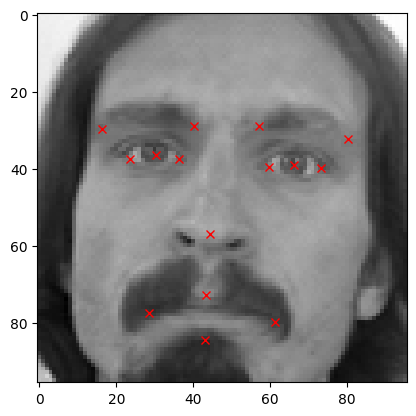

In [249]:
# Show the Original image
plt.imshow(keyfacial_df['Image'][0], cmap = 'gray')
for j in range(1, 31, 2):
        plt.plot(keyfacial_df.loc[0][j-1], keyfacial_df.loc[0][j], 'rx')

<ipython-input-250-fe6d77f074d9>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(keyfacial_df_copy.loc[0][j-1], keyfacial_df_copy.loc[0][j], 'rx')


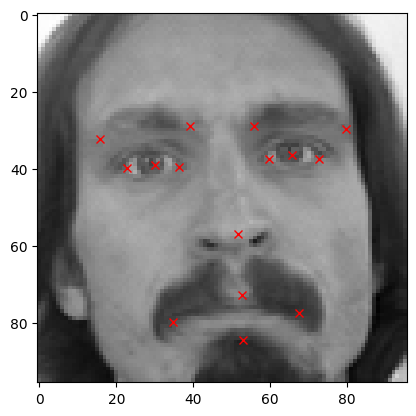

In [250]:
# Show the Horizontally flipped image
plt.imshow(keyfacial_df_copy['Image'][0],cmap='gray')
for j in range(1, 31, 2):
        plt.plot(keyfacial_df_copy.loc[0][j-1], keyfacial_df_copy.loc[0][j], 'rx')

In [251]:
#concatenate the original dataframe with the augmented dataframe
augmented_df = np.concatenate((keyfacial_df, keyfacial_df_copy))

In [252]:
augmented_df.shape

(4280, 31)

In [253]:
#Randomingly increasing the brightness of the images
#we multiply pixel values by random values between 1.5 and 2 to increase the brightness of the image
#we clip the value between 0 and 255

import random

keyfacial_df_copy = copy.copy(keyfacial_df)
keyfacial_df_copy['Image'] = keyfacial_df_copy['Image'].apply(lambda x:np.clip(random.uniform(1.5, 2)* x, 0.0, 255.0))
augmented_df = np.concatenate((augmented_df, keyfacial_df_copy))
augmented_df.shape

(6420, 31)

<ipython-input-254-f778d7efe0bb>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(keyfacial_df_copy.loc[0][j-1], keyfacial_df_copy.loc[0][j], 'rx')


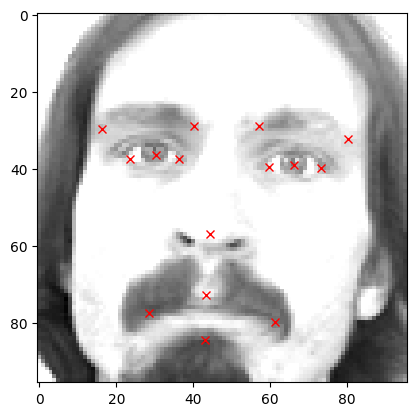

In [254]:
# Show Image with increased brightness

plt.imshow(keyfacial_df_copy['Image'][0], cmap='gray')
for j in range(1, 31, 2):
        plt.plot(keyfacial_df_copy.loc[0][j-1], keyfacial_df_copy.loc[0][j], 'rx')

- Augment images by flipping them vertically
(Hint: Flip along x-axis and note that if we are flipping along x-axis, x co-ordinates won't change)

In [255]:
keyfacial_df_copy = copy.copy(keyfacial_df)

In [256]:
#the goal from this code is the augmentation of data training
keyfacial_df_copy['Image'] = keyfacial_df_copy['Image'].apply(lambda x: np.flip(x, axis = 0))

for i in range(len(columns)):
  if i%2 == 1:
    keyfacial_df_copy[columns[i]] = keyfacial_df_copy[columns[i]].apply(lambda x: 96. - float(x) )

<ipython-input-257-5bfabd4c77e5>:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(keyfacial_df_copy.loc[0][j-1], keyfacial_df_copy.loc[0][j], 'rx')


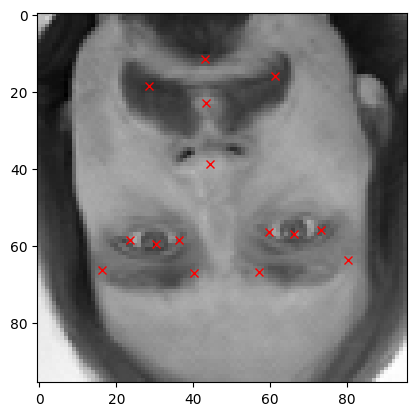

In [257]:
keyfacial_df_copy = copy.copy(keyfacial_df)

# Atualiza as coordenadas Y dos pontos faciais ANTES da inversão da imagem
for i in range(len(columns)):
  if i % 2 == 1:  # Índices ímpares representam as coordenadas Y
    keyfacial_df_copy[columns[i]] = keyfacial_df_copy[columns[i]].apply(lambda x: 96. - float(x))

# Inverte a imagem verticalmente
keyfacial_df_copy['Image'] = keyfacial_df_copy['Image'].apply(lambda x: np.flip(x, axis=0))

plt.imshow(keyfacial_df_copy['Image'][0], cmap='gray')
for j in range(1, 31, 2):
        plt.plot(keyfacial_df_copy.loc[0][j-1], keyfacial_df_copy.loc[0][j], 'rx')

#PERFORM DATA NORMALIZATION AND TRAINING DATA PREPARATION


In [258]:
#Obtain the value of images which is present in the 31st column
img = augmented_df[:,30]

#normalize the images
img = img/255.

#create an empty array of shape to feed the model
X = np.empty((len(img), 96, 96, 1))

#iterate through the img list and add image values to the empty array after expading its dimension
for i in range(len(img)):
  X[i,] = np.expand_dims(img[i], axis = 2)

# Convert the array type to float32
X = np.asarray(X).astype(np.float32)
X.shape


(6420, 96, 96, 1)

In [259]:
# Obtain the value of x & y coordinates which are to used as target.
#this code takes the augmented facial key-point data, converts it into a numpy array with the appropriate data type
y = augmented_df[:,:30]
y = np.asarray(y).astype(np.float32)
y.shape

(6420, 30)

In [260]:
# Split the data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [261]:
X_train.shape

(5136, 96, 96, 1)

In [262]:
X_test.shape

(1284, 96, 96, 1)

- divide data into 80% training and 20% testing
- Gradient descent is an optimization algorithm used to obtain the optimized network weight and bias values

- Convolutional neural networks - CNN
Designed to process grid-like data, such as images, using layers that perform convolutions to extract spatial features.
--resnet (residual network)

#BUILD DEEP RESIDUAL NEURAL NETWORK KEY FACIAL POINTS DETECTION MODEL


In simple terms, the res_block function creates a block of layers that learn to extract and refine features from images. The "shortcut" allows the network to learn "residuals" or differences relative to the input, which helps train deeper networks and avoid issues like vanishing gradients.

In [263]:
def res_block(X, filter, stage):

  # Convolutional_block
  X_copy = X

  f1 , f2, f3 = filter

  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_conv_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = MaxPool2D((2,2))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_a')(X)
  X = Activation('relu')(X)

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_conv_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_b')(X)
  X = Activation('relu')(X)

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_c')(X)


  # Short path
  X_copy = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_copy', kernel_initializer= glorot_uniform(seed = 0))(X_copy)
  X_copy = MaxPool2D((2,2))(X_copy)
  X_copy = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_copy')(X_copy)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Identity Block 1
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_1_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_a')(X)
  X = Activation('relu')(X)

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_1_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_b')(X)
  X = Activation('relu')(X)

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_1_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Identity Block 2
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_2_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_a')(X)
  X = Activation('relu')(X)

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_2_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_b')(X)
  X = Activation('relu')(X)

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_2_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [264]:
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.layers import Input, ZeroPadding2D, Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform
input_shape = (96, 96, 1)

# Formato do tensor de entrada
X_input = Input(input_shape)

# Preenchimento com zeros
X = ZeroPadding2D((3,3))(X_input)

# 1 - estágio
X = Conv2D(64, (7,7), strides= (2,2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3,3), strides= (2,2))(X)

# 2 - estágio
X = res_block(X, filter= [64,64,256], stage= 2)

# 3 - estágio
X = res_block(X, filter= [128,128,512], stage= 3)


# Average Pooling
X = AveragePooling2D((2,2), name = 'Average_Pooling')(X)

# Camada final
X = Flatten()(X)
X = Dense(4096, activation = 'relu')(X)
X = Dropout(0.2)(X)
X = Dense(2048, activation = 'relu')(X)
X = Dropout(0.1)(X)
output_tensor = Dense(30, activation = None, name='output_layer')(X) # Dê um nome à camada de saída e atribua o resultado a uma nova variável


model_1_facialKeyPoints = Model( inputs= X_input, outputs = output_tensor) # Use a nova variável como saída do modelo
model_1_facialKeyPoints.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11            │ (None, 96, 96, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_11         │ (None, 102, 102, 1)    │              0 │ input_layer_11[0][0]   │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1 (Conv2D)            │ (None, 48, 48, 64)     │          3,200 │ zero_padding2d_11[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_conv1                  │ (None, 48, 48, 64)     │            256 │ conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_173            │ (None, 48, 48, 64)     │              0 │ bn_conv1[0][0]         │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_47          │ (None, 23, 23, 64)     │              0 │ activation_173[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res_2_conv_a (Conv2D)     │ (None, 23, 23, 64)     │          4,160 │ max_pooling2d_47[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_48          │ (None, 11, 11, 64)     │              0 │ res_2_conv_a[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_2_conv_a               │ (None, 11, 11, 64)     │            256 │ max_pooling2d_48[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_174            │ (None, 11, 11, 64)     │              0 │ bn_2_conv_a[0][0]      │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res_2_conv_b (Conv2D)     │ (None, 11, 11, 64)     │         36,928 │ activation_174[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_2_conv_b               │ (None, 11, 11, 64)     │            256 │ res_2_conv_b[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_175            │ (None, 11, 11, 64)     │              0 │ bn_2_conv_b[0][0]      │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res_2_conv_copy (Conv2D)  │ (None, 23, 23, 256)    │         16,640 │ max_pooling2d_47[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res_2_conv_c (Conv2D)

 Total params: 18,016,286 (68.73 MB)

 Trainable params: 18,007,710 (68.69 MB)

 Non-trainable params: 8,576 (33.50 KB)

# Compile and train key facial points detection deep learning model

In [265]:
adam = tf.keras.optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)
model_1_facialKeyPoints.compile(loss = "mean_squared_error", optimizer = adam , metrics = ['accuracy'])
# Check this out for more information on Adam optimizer: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam

In [266]:
# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath = "FacialKeyPoints_weights.keras", verbose = 1, save_best_only = True)

In [267]:
X_train.shape


(5136, 96, 96, 1)

In [268]:
y_train.shape

(5136, 30)

In [269]:
history = model_1_facialKeyPoints.fit(X_train, y_train, batch_size = 32, epochs = 2, validation_split = 0.05, callbacks=[checkpointer])

Epoch 1/2
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.4582 - loss: 585.0675
Epoch 1: val_loss improved from inf to 974.90381, saving model to FacialKeyPoints_weights.keras
153/153 ━━━━━━━━━━━━━━━━━━━━ 52s 185ms/step - accuracy: 0.4587 - loss: 582.9622 - val_accuracy: 0.6926 - val_loss: 974.9038
Epoch 2/2
151/153 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6072 - loss: 107.3387
Epoch 2: val_loss improved from 974.90381 to 492.46899, saving model to FacialKeyPoints_weights.keras
153/153 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.6069 - loss: 107.1991 - val_accuracy: 0.1712 - val_loss: 492.4690


In [270]:
# save the model architecture to json file for future use

model_json = model_1_facialKeyPoints.to_json()
with open("/content/drive/My Drive/Emotion AI Dataset/FacialKeyPoints-model.json","w") as json_file:
  json_file.write(model_json)


#ASSESS TRAINED KEY FACIAL POINTS DETECTION MODEL PERFORMANCE


In [271]:
# load the model architecture
# Correct the file path to the actual JSON file containing the model architecture
with open('/content/drive/My Drive/Emotion AI Dataset/detection.json', 'r') as json_file:
    json_savedModel= json_file.read()

model_1_facialKeyPoints.load_weights('/content/drive/My Drive/Emotion AI Dataset/weights_keypoint.hdf5')
adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model_1_facialKeyPoints.compile(loss="mean_squared_error", optimizer= adam , metrics = ['accuracy'])

In [272]:
# Evaluate the model

result = model_1_facialKeyPoints.evaluate(X_test, y_test)
print("Accuracy : {}".format(result[1]))

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8507 - loss: 9.5060
Accuracy : 0.836448609828949


In [273]:
# Get the model keys
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

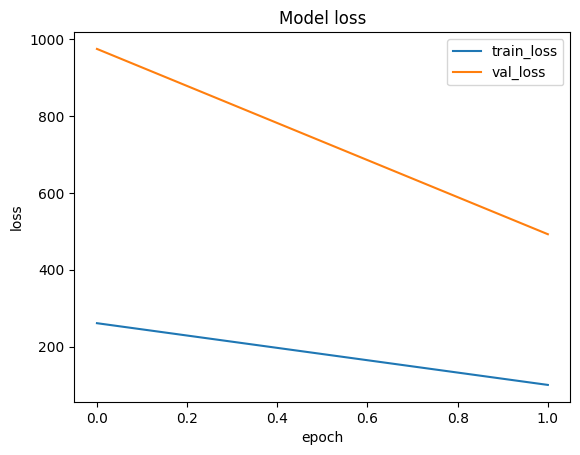

In [274]:
# Plot the training artifacts

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'], loc = 'upper right')
plt.show()

- Both the training loss and validation loss are decreasing as the epochs progress. This indicates that the model is learning and adjusting its weights

- The val_loss curve (validation) is above the train_loss curve (training). This suggests that the model is fitting the training data better than the validation data

-Overall, the behavior so far seems expected, and the model is still learning effectively from the data

#Facial expression detection

0 = angry
1 = disgust
2 = Sad
3 = Happy
4 = Surprise

# Import & Explore dataset for facial expression detenction




In [275]:
#read the csv files for the facial expression data
facialexpression_df = pd.read_csv('/content/drive/My Drive/Emotion AI Dataset/icml_face_data.csv')

In [276]:
facialexpression_df

emotion                                             pixels
0            0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1            0  151 150 147 155 148 133 111 140 170 174 182 15...
2            2  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
3            2  20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...
4            3  77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...
...        ...                                                ...
24563        3  0 39 81 80 104 97 51 64 68 46 41 67 53 68 70 5...
24564        0  181 177 176 156 178 144 136 132 122 107 131 16...
24565        3  178 174 172 173 181 188 191 194 196 199 200 20...
24566        0  17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...
24567        3  30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...

[24568 rows x 2 columns]

In [277]:
facialexpression_df[' pixels'][0] #string format

'70 80 82 72 58 58 60 63 54 58 60 48 89 115 121 119 115 110 98 91 84 84 90 99 110 126 143 153 158 171 169 172 169 165 129 110 113 107 95 79 66 62 56 57 61 52 43 41 65 61 58 57 56 69 75 70 65 56 54 105 146 154 151 151 155 155 150 147 147 148 152 158 164 172 177 182 186 189 188 190 188 180 167 116 95 103 97 77 72 62 55 58 54 56 52 44 50 43 54 64 63 71 68 64 52 66 119 156 161 164 163 164 167 168 170 174 175 176 178 179 183 187 190 195 197 198 197 198 195 191 190 145 86 100 90 65 57 60 54 51 41 49 56 47 38 44 63 55 46 52 54 55 83 138 157 158 165 168 172 171 173 176 179 179 180 182 185 187 189 189 192 197 200 199 196 198 200 198 197 177 91 87 96 58 58 59 51 42 37 41 47 45 37 35 36 30 41 47 59 94 141 159 161 161 164 170 171 172 176 178 179 182 183 183 187 189 192 192 194 195 200 200 199 199 200 201 197 193 111 71 108 69 55 61 51 42 43 56 54 44 24 29 31 45 61 72 100 136 150 159 163 162 163 170 172 171 174 177 177 180 187 186 187 189 192 192 194 195 196 197 199 200 201 200 197 201 137 58 98 92

In [278]:
# function to convert pixel values in string format to array format

def string2array(x):
  return np.array(x.split(' ')).reshape(48, 48, 1).astype('float32')

In [279]:
# Resize images from (48, 48) to (96, 96)

def resize(x):

  img = x.reshape(48, 48)
  return cv2.resize(img, dsize=(96, 96), interpolation = cv2.INTER_CUBIC)

In [280]:
facialexpression_df[' pixels'] = facialexpression_df[' pixels'].apply(lambda x: string2array(x))

In [281]:
facialexpression_df[' pixels'] = facialexpression_df[' pixels'].apply(lambda x: resize(x))


In [282]:
facialexpression_df.head()

emotion                                             pixels
0        0  [[69.316925, 73.03865, 79.13719, 84.17186, 85....
1        0  [[151.09435, 150.91393, 150.65791, 148.96367, ...
2        2  [[23.061905, 25.50914, 29.47847, 33.99843, 36....
3        2  [[20.083221, 19.079437, 17.398712, 17.158691, ...
4        3  [[76.26172, 76.54747, 77.001785, 77.7672, 78.4...

In [283]:
# check the shape of data_frame
facialexpression_df.shape

(24568, 2)

In [284]:
# check for the presence of null values in the data frame
facialexpression_df.isnull().sum()

emotion    0
 pixels    0
dtype: int64

In [285]:
label_to_text = {0:'anger', 1:'disgust', 2:'sad', 3:'happiness', 4: 'surprise'}

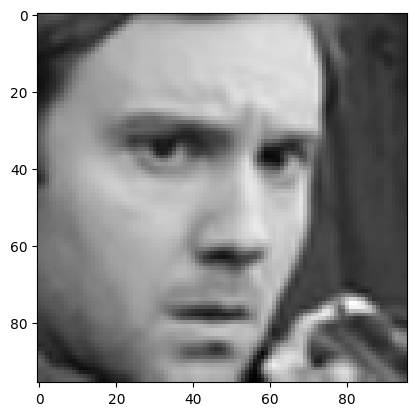

In [286]:
plt.imshow(facialexpression_df[' pixels'][0], cmap= 'gray')

#visualize images and plot labels

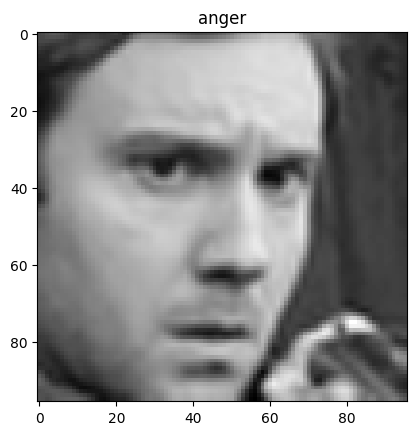

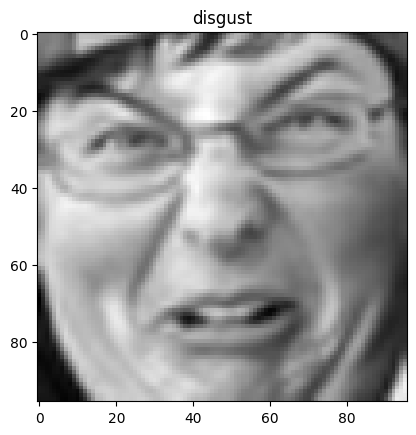

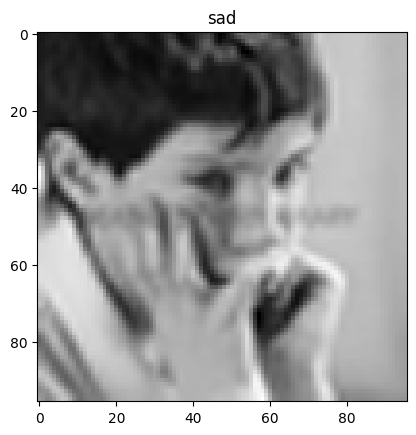

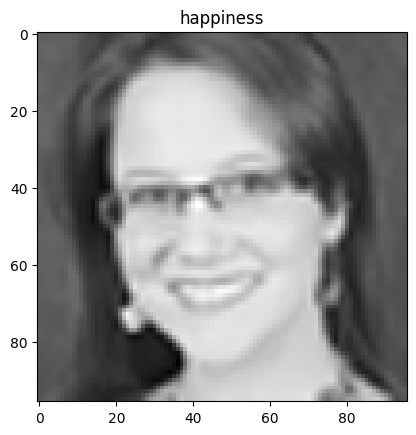

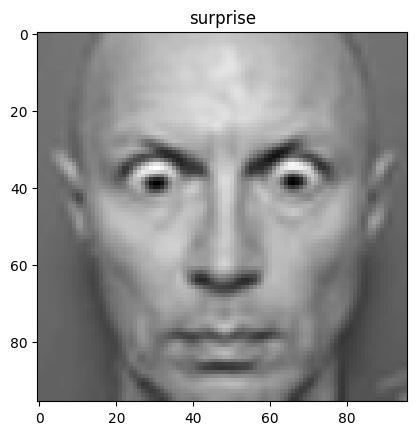

In [287]:
emotions = [0, 1, 2, 3, 4]

for i in emotions:
  data = facialexpression_df[facialexpression_df['emotion'] == i][:1]
  img = data[' pixels'].item()
  img = img.reshape(96, 96)
  plt.figure()
  plt.title(label_to_text[i])
  plt.imshow(img, cmap = 'gray')

Text(0.5, 1.0, 'number of images per emotion')

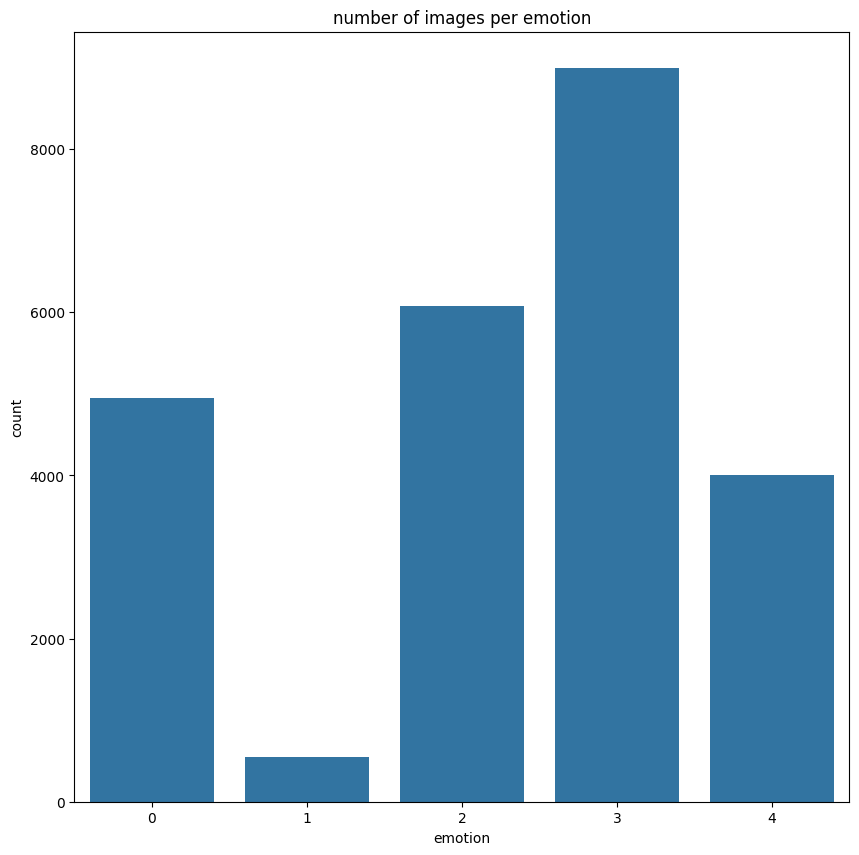

In [288]:
#plot bar chart to outline how many samples (images) are present per emotion
plt.figure(figsize = (10, 10))
sns.barplot(x = facialexpression_df.emotion.value_counts().index, y = facialexpression_df.emotion.value_counts())
plt.title('number of images per emotion')

In [289]:
facialexpression_df.emotion.value_counts().index

Index([3, 2, 0, 4, 1], dtype='int64', name='emotion')

In [290]:
facialexpression_df.emotion.value_counts()

emotion
3    8989
2    6077
0    4953
4    4002
1     547
Name: count, dtype: int64

# TASK #14: PERFORM DATA PREPARATION AND IMAGE AUGMENTATION

In [291]:
#split the dataframe in to features and labels
#this preparation is essencial for training a model that can effectively
#learn to associate facial images (x) with their respective emotions(y)
from keras.utils import to_categorical

X= facialexpression_df[' pixels']
y= to_categorical(facialexpression_df['emotion'])

In [292]:

X[0]

array([[ 69.316925,  73.03865 ,  79.13719 , ...,  40.73619 ,  40.6584  ,
         40.5394  ],
       [ 68.66325 ,  70.95224 ,  74.71768 , ...,  43.274765,  42.037186,
         41.223618],
       [ 67.768814,  67.71646 ,  67.67172 , ...,  47.39473 ,  44.26329 ,
         42.31465 ],
       ...,
       [ 74.89021 ,  76.79553 ,  79.90259 , ...,  71.463425,  59.32875 ,
         51.74736 ],
       [ 76.68126 ,  75.808105,  74.25452 , ...,  93.943375,  79.77934 ,
         71.13246 ],
       [ 77.63858 ,  75.15074 ,  70.8846  , ..., 107.66351 ,  92.23212 ,
         82.91585 ]], dtype=float32)

In [293]:
y

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [294]:

X = np.stack(X, axis = 0)
X = X.reshape(24568, 96, 96, 1)

print(X.shape, y.shape)

(24568, 96, 96, 1) (24568, 5)


In [295]:
# split the dataframe in to train, test and validation data frames

from sklearn.model_selection import train_test_split

X_train, X_Test, y_train, y_Test = train_test_split(X, y, test_size = 0.1, shuffle = True)
X_val, X_Test, y_val, y_Test = train_test_split(X_Test, y_Test, test_size = 0.5, shuffle = True)


In [296]:
print(X_val.shape, y_val.shape)

(1228, 96, 96, 1) (1228, 5)


In [297]:
print(X_Test.shape, y_Test.shape)

(1229, 96, 96, 1) (1229, 5)


In [298]:
print(X_train.shape, y_train.shape)

(22111, 96, 96, 1) (22111, 5)


Understanding the shape of your datasets is crucial for building and training deep learning models. It ensures that the data is correctly formatted and that the model's input and output layers are properly defined.
By printing the shapes, the user can verify that the data has been split and prepared for the validation phase of the model training process.
- the input format is in the standard required for deep learning models (N, HEIGHT, WIDTH, CHANNELS)
- the output format has the correct number of values for each sample
- the data split (train, validation, test) is consistent

In [299]:
# image pre-processing

X_train = X_train/255
X_val   = X_val /255
X_Test  = X_Test/255

In [300]:
X_train

array([[[[0.4413956 ],
         [0.44517744],
         [0.4512655 ],
         ...,
         [0.07945234],
         [0.08064264],
         [0.08139487]],

        [[0.44330624],
         [0.44599938],
         [0.45027986],
         ...,
         [0.08018655],
         [0.08381467],
         [0.086047  ]],

        [[0.44657102],
         [0.4474081 ],
         [0.44860834],
         ...,
         [0.08134263],
         [0.08909242],
         [0.09382719]],

        ...,

        [[0.00392157],
         [0.0037083 ],
         [0.00328178],
         ...,
         [0.06380975],
         [0.05699391],
         [0.05243889]],

        [[0.00392157],
         [0.0038591 ],
         [0.00373415],
         ...,
         [0.067772  ],
         [0.05441033],
         [0.04592536]],

        [[0.00392157],
         [0.00395065],
         [0.00400881],
         ...,
         [0.07020281],
         [0.05276579],
         [0.04183386]]],


       [[[0.10100432],
         [0.09635088],
         [0.08

In [301]:
#augment the image data used to train a model
train_datagen = ImageDataGenerator(
rotation_range = 15,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True,
    fill_mode = "nearest")

#setting uo a system for automatically creating many slightly modified versions of the training images


#BUILD AND TRAIN DEEP LEARNING MODEL FOR FACIAL EXPRESSION CLASSIFICATION

In [302]:
#building a CNN ResNet
#extracting features and ultimately producing a probability distribution representing the likelihood of each emotion
input_shape = (96, 96, 1)

# Input tensor shape
X_input = Input(input_shape)

# Zero-padding
X = ZeroPadding2D((3, 3))(X_input)

# 1 - stage
X = Conv2D(64, (7, 7), strides= (2, 2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3, 3), strides= (2, 2))(X)

# 2 - stage
X = res_block(X, filter= [64, 64, 256], stage= 2)

# 3 - stage
X = res_block(X, filter= [128, 128, 512], stage= 3)

# 4 - stage
# X = res_block(X, filters= [256, 256, 1024], stage= 4)

# Average Pooling
X = AveragePooling2D((4, 4), name = 'Averagea_Pooling')(X)

# Final layer
X = Flatten()(X)
X = Dense(5, activation = 'softmax', name = 'Dense_final', kernel_initializer= glorot_uniform(seed=0))(X)

model_2_emotion = Model( inputs= X_input, outputs = X, name = 'Resnet18')

model_2_emotion.summary()

Model: "Resnet18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12            │ (None, 96, 96, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_12         │ (None, 102, 102, 1)    │              0 │ input_layer_12[0][0]   │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1 (Conv2D)            │ (None, 48, 48, 64)     │          3,200 │ zero_padding2d_12[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_conv1                  │ (None, 48, 48, 64)     │            256 │ conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_192            │ (None, 48, 48, 64)     │              0 │ bn_conv1[0][0]         │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_52          │ (None, 23, 23, 64)     │              0 │ activation_192[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res_2_conv_a (Conv2D)     │ (None, 23, 23, 64)     │          4,160 │ max_pooling2d_52[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_53          │ (None, 11, 11, 64)     │              0 │ res_2_conv_a[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_2_conv_a               │ (None, 11, 11, 64)     │            256 │ max_pooling2d_53[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_193            │ (None, 11, 11, 64)     │              0 │ bn_2_conv_a[0][0]      │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res_2_conv_b (Conv2D)     │ (None, 11, 11, 64)     │         36,928 │ activation_193[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_2_conv_b               │ (None, 11, 11, 64)     │            256 │ res_2_conv_b[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_194            │ (None, 11, 11, 64)     │              0 │ bn_2_conv_b[0][0]      │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res_2_conv_copy (Conv2D)  │ (None, 23, 23, 256)    │         16,640 │ max_pooling2d_52[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res_2_conv_c (Conv2D)

 Total params: 1,174,021 (4.48 MB)

 Trainable params: 1,165,445 (4.45 MB)

 Non-trainable params: 8,576 (33.50 KB)

In [303]:
# train the network
model_2_emotion.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [304]:
# Recall that the first facial key points model was saved as follows: FacialKeyPoints_weights.hdf5 and FacialKeyPoints-model.json

# using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath = "FacialExpression_weights.keras", verbose = 1, save_best_only=True)

In [305]:
history = model_2_emotion.fit(train_datagen.flow(X_train, y_train, batch_size=64),
	validation_data=(X_val, y_val), steps_per_epoch=len(X_train) // 64,
	epochs= 2, callbacks=[checkpointer, earlystopping])

Epoch 1/2


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.4001 - loss: 1.5361
Epoch 1: val_loss improved from inf to 1.17726, saving model to FacialExpression_weights.keras
345/345 ━━━━━━━━━━━━━━━━━━━━ 64s 112ms/step - accuracy: 0.4004 - loss: 1.5353 - val_accuracy: 0.5041 - val_loss: 1.1773
Epoch 2/2
  1/345 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.5000 - loss: 1.1072

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss did not improve from 1.17726
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5000 - loss: 1.1072 - val_accuracy: 0.4870 - val_loss: 1.2085


In [306]:
# saving the model architecture to json file for future use

model_json = model_2_emotion.to_json()
with open("/content/drive/My Drive/Emotion AI Dataset/FacialExpression-model.json","w") as json_file:
  json_file.write(model_json)

#UNDERSTANT HOW TO ASSESS CLASSIFIER MODELS (CONFUSION MATRIX, ACCURACY, PRECISION AND RECALL)

- Confusion Matrix: is used to describe the performance of a classification model
- Precision vs. recall example: accuracy is generally misleading and is not enough to assess the performance of a classifier
- is an important KPI in situations where:
Dataset is highly imbalanced; cases when you have small cancer patients compared to healthy ones



#ASSESS THE PERFORMANCE OF TRAINED FACIAL EXPRESSION CLASSIFIER MODEL

In [307]:
y_Test

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.]])

In [308]:
print(y_Test.shape)

(1229, 5)


In [309]:
print(X_Test.shape)

(1229, 96, 96, 1)


In [310]:
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.models import Model  # Importe explicitamente Model
from tensorflow.keras.layers import Input, ZeroPadding2D, Conv2D, BatchNormalization, Activation, MaxPooling2D, AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.initializers import glorot_uniform

# Define the res_block function here or ensure it is already defined

with open('/content/drive/My Drive/Emotion AI Dataset/emotion.json', 'r') as json_file:
    loaded_model_json= json_file.read()

# Load the model architecture
# Pass res_block to custom_objects
model_2_emotion.load_weights('/content/drive/My Drive/Emotion AI Dataset/weights_emotions.hdf5')
model_2_emotion.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [311]:
score = model_2_emotion.evaluate(X_Test, y_Test)
print('Test Accuracy: {}'.format(score[1]))

39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8557 - loss: 0.3859
Test Accuracy: 0.8567941188812256


In [312]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [313]:
#this information is often used to plot learning curves and analyze the models learning progress and potential overfitting
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

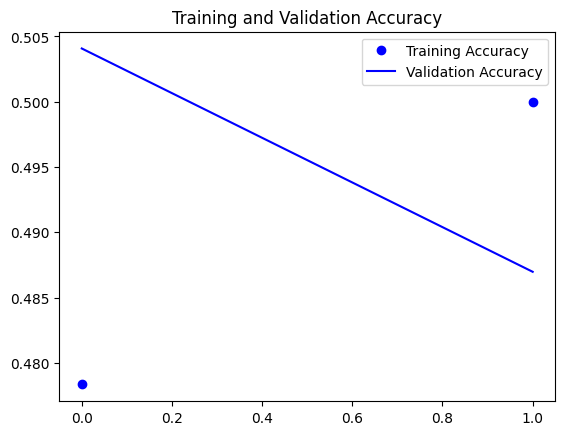

In [314]:
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

indicates that model is not learning effectivelu from the data, possible causes:
Overfitting, insufficient data, model architecture, data preprocessing

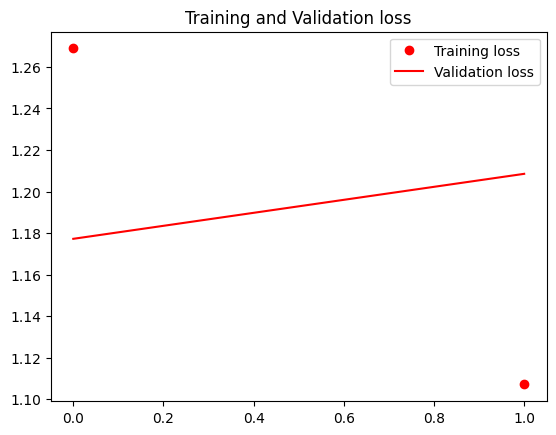

In [315]:
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

In [316]:
# predicted_classes = model.predict_classes(X_test)
predicted_classes = np.argmax(model_2_emotion.predict(X_Test), axis=-1)
y_true = np.argmax(y_Test, axis=-1)

39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step


In [317]:
y_true.shape

(1229,)

<Axes: >

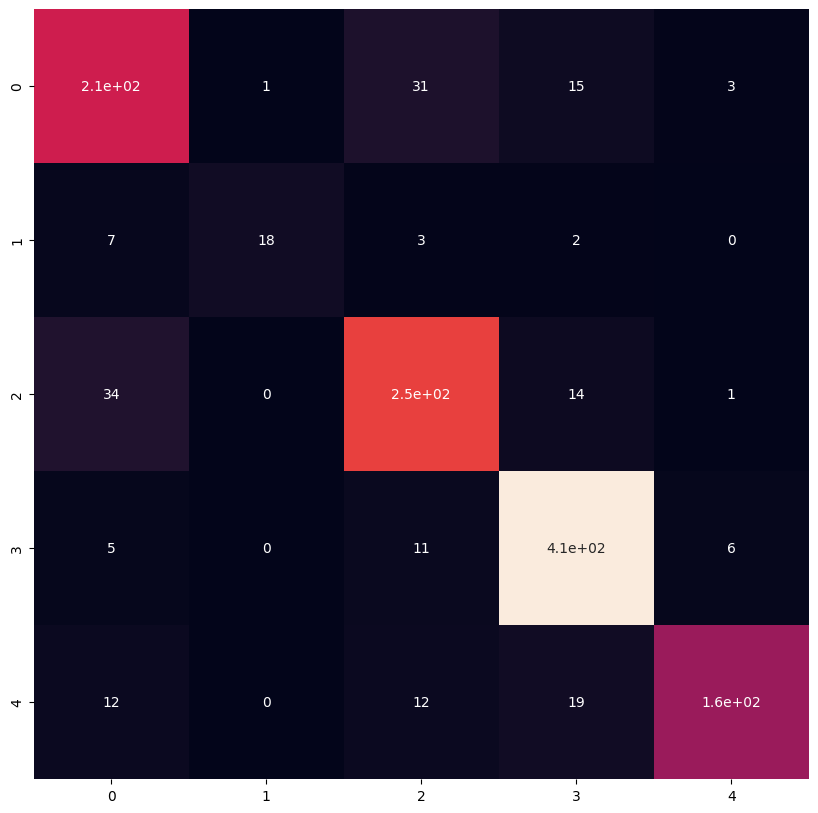

In [318]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, predicted_classes)
plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True, cbar = False)

- Print out a grid of 25 images along with their predicted/true label

- Print out the classification report and analyze precision and recall

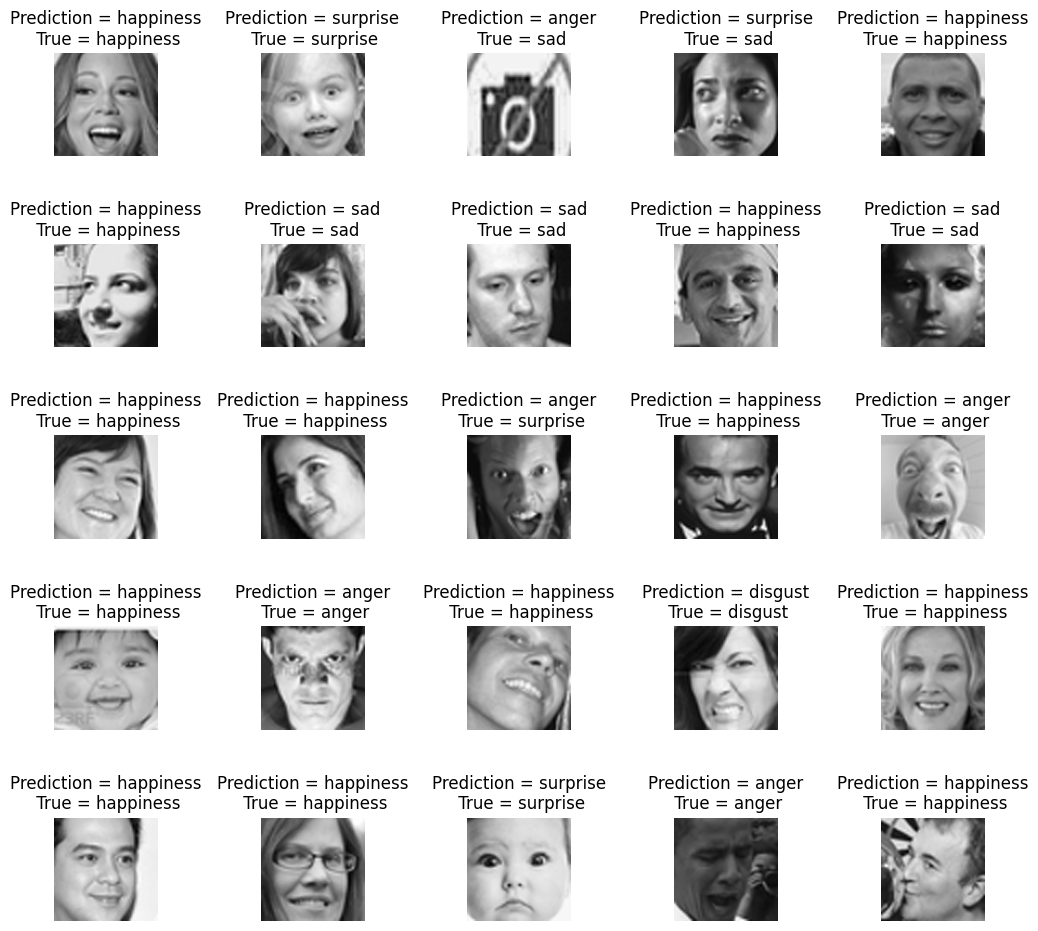

In [319]:
L = 5
W = 5
fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
  axes[i].imshow(X_Test[i].reshape(96, 96), cmap = 'gray')
  axes[i].set_title('Prediction = {}\n True = {}'.format(label_to_text[predicted_classes[i]], label_to_text[y_true[i]]))
  axes[i].axis('off')

plt.subplots_adjust(wspace = 1)

In [320]:
#precision and recall
from sklearn.metrics import classification_report
print(classification_report(y_true, predicted_classes))

              precision    recall  f1-score   support

           0       0.78      0.81      0.80       261
           1       0.95      0.60      0.73        30
           2       0.81      0.84      0.83       299
           3       0.89      0.95      0.92       436
           4       0.94      0.79      0.86       203

    accuracy                           0.86      1229
   macro avg       0.88      0.80      0.83      1229
weighted avg       0.86      0.86      0.86      1229



- High precision means the model is making very few false positive predictions for that emotion

- High recall means the model is missing very few true positive cases for that emotion

- F1-score: a balanced measure that combines precision and recall, providing a single score to represent overall performance for a specific emotion

- Support: the number of actual images belonging to each emotion class in the test dataset. Distribution of data across different emotions

- Emotion 0 (anger) resonably good performance with 0.78 precision and 0.81 recall.

- Emotion 1(disgust) Perfect precision 1 but lower recall, this means the model rarely misclassifies 'disgust' but might miss identifying some actual 'disgust' images.

- Emotion 2: good performance

- emotion 3: very good performance

- Emotion 4: excellent precision and good recall

Accuracy: The overall accuracy of the model is 0.87, meaning it correctly classified 87% of the images in the test set

- To improve overall performance, you could focus on collecting more data for under-represented emotions like disgust


#Combine both models(1) facial key points detection and (2) facial expression models


In [321]:
def predict(X_test):

  #Making prediction for the keypoint model
  df_predict = model_1_facialKeyPoints.predict(X_test)

  #making prediction for the emotion model
  df_emotion = np.argmax(model_2_emotion.predict(X_test), axis=-1)

  #Reshaping array from (856,) to (856, 1)
  df_emotion = np.expand_dims(df_emotion, axis = 1)

  #Converting the predictions into a dataframe
  df_predict = pd.DataFrame(df_predict, columns = columns)

  #Adding emotion into the predicted dataframe
  df_predict['emotion'] = df_emotion

  return df_predict

In [322]:
df_predict = predict(X_test)

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


In [323]:
df_predict.head()

left_eye_center_x  left_eye_center_y  right_eye_center_x  \
0          65.790787          36.410095           29.140907   
1          64.738670          38.615490           30.081373   
2          66.895325          37.283710           31.440842   
3          65.077820          35.947769           31.798693   
4          66.066528          36.185047           30.303938   

   right_eye_center_y  left_eye_inner_corner_x  left_eye_inner_corner_y  \
0           35.992104                59.873463                37.105640   
1           37.118340                59.068378                38.982388   
2           38.149197                59.355663                38.545155   
3           35.843979                59.275063                36.629608   
4           39.759766                59.767879                36.736870   

   left_eye_outer_corner_x  left_eye_outer_corner_y  right_eye_inner_corner_x  \
0                72.318161                37.539135                 35.601650   
1                70.281845                39.605194                 35.458179   
2                73.657356                38.126575                 38.100124   
3                70.654869                36.516357                 37.332401   
4                72.186340                36.330517                 36.600971   

   right_eye_inner_corner_y  ...  nose_tip_y  mouth_left_corner_x  \
0                 36.679951  ...   50.793381            61.682060   
1                 37.864178  ...   57.108276            58.839527   
2                 38.911163  ...   61.431396            64.324799   
3                 36.437477  ...   56.298855            61.035458   
4                 38.891987  ...   47.289871            65.136047   

   mouth_left_corner_y  mouth_right_corner_x  mouth_right_corner_y  \
0            74.570740             33.729168             74.780731   
1            80.611519             32.905548             80.219612   
2            80.669067             34.836540             81.556450   
3            75.286293             35.319664             75.390091   
4            72.227661             38.362354             75.182144   

   mouth_center_top_lip_x  mouth_center_top_lip_y  mouth_center_bottom_lip_x  \
0               47.922562               66.024796                  47.944809   
1               46.463692               71.879097                  45.999542   
2               49.611664               80.494698                  49.554329   
3               48.337971               71.146309                  48.254135   
4               50.232212               64.829086                  51.706108   

   mouth_center_bottom_lip_y  emotion  
0                  83.521385        4  
1                  93.293350        0  
2                  82.581032        0  
3                  83.310310        0  
4                  79.248268        2  

[5 rows x 31 columns]

<ipython-input-324-fc2fc4c033bd>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axes[i].plot(df_predict.loc[i][j-1], df_predict.loc[i][j], 'rx')


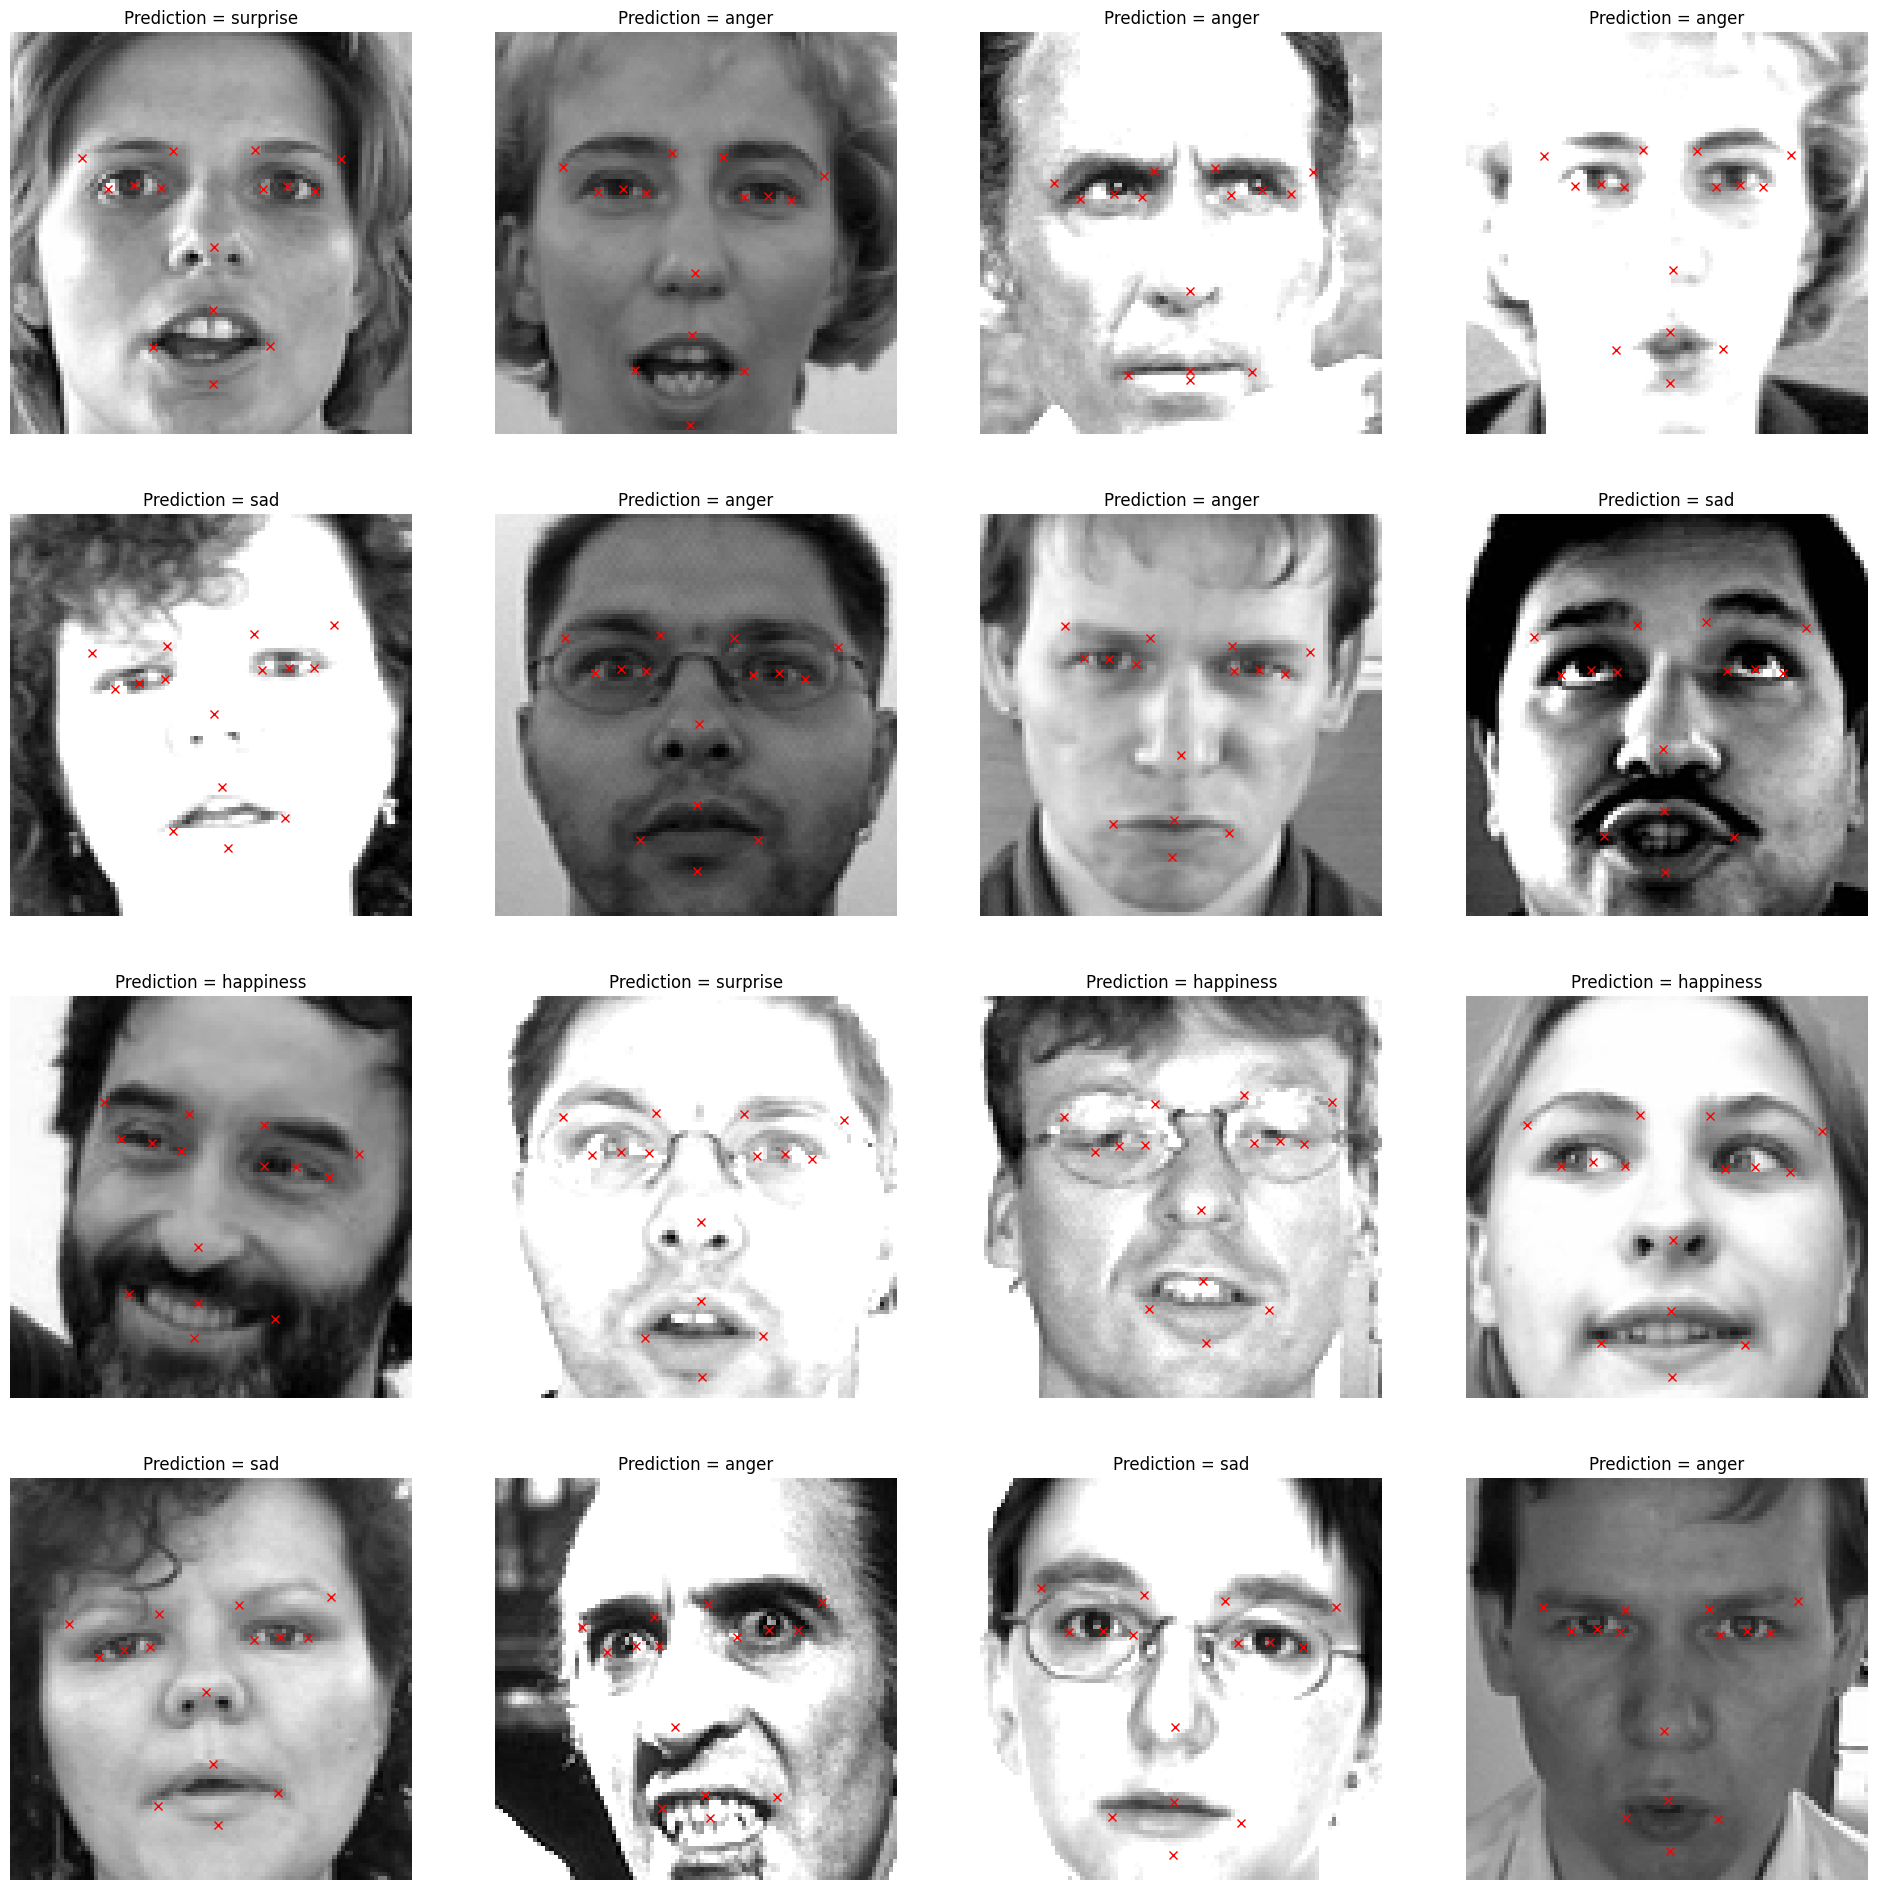

In [324]:
#plot a grid of 16 images along with their predicted emotion and facial key points
#plotting the test images and their predicted keypoints and emotions
fig, axes = plt.subplots(4, 4, figsize = (24, 24))
axes = axes.ravel()

for i in range(16):
  axes[i].imshow(X_test[i].squeeze(), cmap = 'gray')
  axes[i].set_title('Prediction = {}'.format(label_to_text[df_predict['emotion'][i]]))
  axes[i].axis('off')
  for j in range(1,31,2):
         axes[i].plot(df_predict.loc[i][j-1], df_predict.loc[i][j], 'rx')
